<a href="https://colab.research.google.com/github/KevinSBSon/ResNet_ImageClassification/blob/main/ResNet_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Using ResNet

### Import packages

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

### Load Dataset

In [2]:
#Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#generating train and test data from the data folder
train_dir = "drive/My Drive/Colab Notebooks/weather_dataset/weather_dataset/train"
test_dir = "drive/My Drive/Colab Notebooks/weather_dataset/weather_dataset/test"
nh, nw = (120, 120)
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   fill_mode = 'nearest')
train_dataset = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(nh, nw),
                                                   batch_size = 32,
                                                   class_mode='categorical',
                                                   shuffle=True)

test_datagen = ImageDataGenerator(rescale = 1.0/255)
test_dataset = test_datagen.flow_from_directory(test_dir, 
                                              target_size = (nh, nw), 
                                              batch_size = 32,
                                              class_mode = 'categorical'
                                              )

Found 896 images belonging to 4 classes.
Found 229 images belonging to 4 classes.


### Labels

In [ ]:
labels = {value: key for key, value in train_dataset.class_indices.items()}

for key, value in labels.items():
    print(f"{key} : {value}")

0 : cloudy
1 : rain
2 : shine
3 : sunrise


### Sample Images

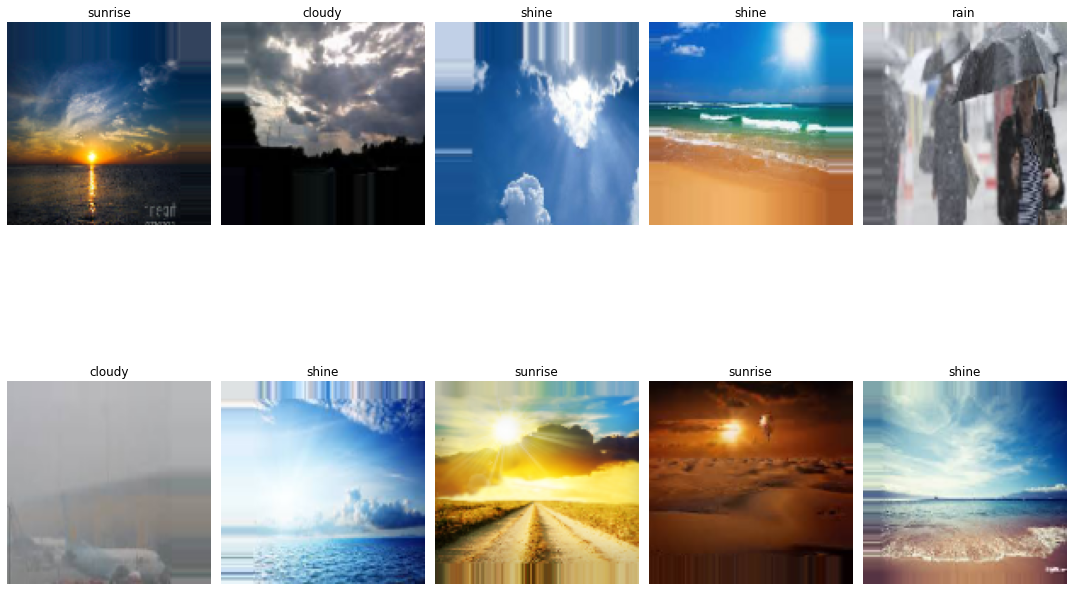

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_dataset[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_dataset[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

### Build Identity Block for ResNet

In [4]:
#Identity Block for ResNet50, ResNet101
def identity_block1(X, f, filters, training=True, initializer=random_uniform, ResNet = True):

    F1, F2, F3 = filters
    
    # Copy Input data for skip connection 
    X_shortcut = X
    
    # First component
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    #check ResNet if True, ResNet
    #if False, Plain NN
    if ResNet == True:
      X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

### Build Convolutional Block

In [5]:
#Convolutional block for ResNet50, ResNet101

def convolutional_block1(X, f, filters, s = 2, training=True, initializer=glorot_uniform, ResNet = True):
    
    F1, F2, F3 = filters
    
    # Copy Input data for skip connection 
    X_shortcut = X

    # First component
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Second component
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X) 

    ## Third component
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    
    #Shortcut
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut) 
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    #check ResNet if True, ResNet
    #if False, Plain NN
    if ResNet == True:
      X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

### Implement ResNet50

In [6]:
# ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 4, RN = True):
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block1(X, f = 3, filters = [64, 64, 256], s = 1, ResNet = RN)
    X = identity_block1(X, 3, [64, 64, 256], ResNet = RN)
    X = identity_block1(X, 3, [64, 64, 256], ResNet = RN)

    # Stage 3
    X = convolutional_block1(X, f = 3, filters = [128, 128, 512], s = 2, ResNet = RN) 
    X = identity_block1(X, 3, [128, 128, 512], ResNet = RN) 
    X = identity_block1(X, 3, [128, 128, 512], ResNet = RN) 
    X = identity_block1(X, 3, [128, 128, 512], ResNet = RN)  
    
    # Stage 4
    X = convolutional_block1(X, f = 3, filters = [256, 256, 1024], s = 2, ResNet = RN) 
    X = identity_block1(X, 3, [256, 256, 1024], ResNet = RN)  
    X = identity_block1(X, 3, [256, 256, 1024], ResNet = RN)  
    X = identity_block1(X, 3, [256, 256, 1024], ResNet = RN)  
    X = identity_block1(X, 3, [256, 256, 1024], ResNet = RN)  
    X = identity_block1(X, 3, [256, 256, 1024], ResNet = RN)  

    # Stage 5 (≈3 lines)
    X = convolutional_block1(X, f = 3, filters = [512, 512, 2048], s = 2, ResNet = RN) 
    X = identity_block1(X, 3, [512, 512, 2048], ResNet = RN)
    X = identity_block1(X, 3, [512, 512, 2048], ResNet = RN)
    
    X = AveragePooling2D(pool_size = (2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

## Build and Compile Model

In [7]:
#Build model
model = ResNet50(input_shape = (nh, nw, 3), classes = 4)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 126, 126, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 60, 60, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 60, 60, 64)  256         ['conv2d[0][0]']             

In [8]:
#Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
#Callback to collect logged accuracy in each epoch
class CustomCheckPoint(Callback):
    def __init__(self,**kargs):
        super(CustomCheckPoint,self).__init__(**kargs)
        self.epoch_accuracy = {} 
        self.epoch_loss = {} 

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_accuracy[epoch] = logs.get("accuracy")
        self.epoch_loss[epoch] = logs.get("loss")
checkpoint = CustomCheckPoint()

### Train the model using training data

In [12]:
model.fit( train_dataset, epochs = 60, batch_size = 32, callbacks = [checkpoint])

Epoch 1/60
28/28 [==============================] - 10s 366ms/step - loss: 0.5831 - accuracy: 0.7556
Epoch 2/60
28/28 [==============================] - 10s 360ms/step - loss: 0.4702 - accuracy: 0.8170
Epoch 3/60
28/28 [==============================] - 10s 358ms/step - loss: 0.4553 - accuracy: 0.8270
Epoch 4/60
28/28 [==============================] - 10s 358ms/step - loss: 0.3981 - accuracy: 0.8571
Epoch 5/60
28/28 [==============================] - 10s 360ms/step - loss: 0.3518 - accuracy: 0.8661
Epoch 6/60
28/28 [==============================] - 10s 366ms/step - loss: 0.3235 - accuracy: 0.8761
Epoch 7/60
28/28 [==============================] - 10s 360ms/step - loss: 0.3054 - accuracy: 0.8862
Epoch 8/60
28/28 [==============================] - 10s 365ms/step - loss: 0.3123 - accuracy: 0.8929
Epoch 9/60
28/28 [==============================] - 10s 363ms/step - loss: 0.3810 - accuracy: 0.8850
Epoch 10/60
28/28 [==============================] - 10s 364ms/step - loss: 0.2981 - accura

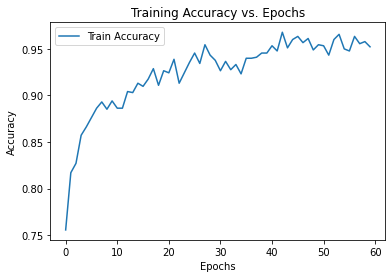

In [13]:
#plot accuracy from each epoch
plt.plot(list(checkpoint.epoch_accuracy.values()), label = 'Train Accuracy')
plt.title("Training Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

### Performance on Testset

In [14]:
preds = model.evaluate(test_dataset)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

8/8 [==============================] - 97s 14s/step - loss: 0.2026 - accuracy: 0.9301
Loss = 0.20257696509361267
Test Accuracy = 0.9301310181617737


After about 15 epochs using ResNet50, we see that Training Accuracy increases higher than 0.9. Also, when using the trained model after 60 epochs to evaluate the test set, it shows its performance higher than 0.9. Even though it uses 50 layers and is trained with the small number of epochs, it shows a good performance in accuracy.

### Build identity block for ResNet18, 34

In [ ]:
#identity block for ResNet18, 34
def identity_block2(X, f, filters, training=True, initializer=random_uniform, ResNet = True):
   
    F1, F2 = filters
    
    # Copy Input data for skip connection
    X_shortcut = X
    
    # First component
    X = Conv2D(filters = F1, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Second component
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    #check ResNet if True, ResNet
    #if False, Plain NN
    if ResNet == True:
      X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

### Build convolutional block for ResNet18, 34

In [ ]:
#convolutional block for ResNet18, ResNet34
def convolutional_block2(X, f, filters, s = 2, training=True, initializer=glorot_uniform, ResNet = True):
    
    F1, F2 = filters
    
    # Copy Input data for skip connection
    X_shortcut = X

    # First component
    X = Conv2D(filters = F1, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X) 

    ## Second component
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    
    #Shortcut
    X_shortcut = Conv2D(filters = F1, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X_shortcut) 
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    #check ResNet if True, ResNet
    #if False, Plain NN
    if ResNet == True:
      X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

### Build ResNet18

In [ ]:
def ResNet18(input_shape = (64, 64, 3), classes = 4, RN = True):

    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block2(X, f = 3, filters = [64, 64], s = 1, ResNet = RN)
    X = identity_block2(X, 3, [64, 64], ResNet = RN)

    # Stage 3 
    X = convolutional_block2(X, f = 3, filters = [128, 128], s = 2, ResNet = RN) 
    X = identity_block2(X, 3, [128, 128], ResNet = RN)  
    
    # Stage 4 
    X = convolutional_block2(X, f = 3, filters = [256, 256], s = 2, ResNet = RN) 
    X = identity_block2(X, 3, [256, 256], ResNet = RN)   

    # Stage 5 
    X = convolutional_block2(X, f = 3, filters = [512, 512], s = 2, ResNet = RN) 
    X = identity_block2(X, 3, [512, 512], ResNet = RN)

    X = AveragePooling2D(pool_size = (2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
modelRN18 = ResNet18(input_shape = (nh, nw, 3), classes = 4)
#Compile model
modelRN18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cpRN18 = CustomCheckPoint()
modelRN18.fit( train_dataset, epochs = 20, batch_size = 32, callbacks = [cpRN18])

Epoch 1/20
28/28 [==============================] - 169s 6s/step - loss: 10.0875 - accuracy: 0.4219
Epoch 2/20
28/28 [==============================] - 12s 406ms/step - loss: 1.8331 - accuracy: 0.5022
Epoch 3/20
28/28 [==============================] - 12s 407ms/step - loss: 1.1928 - accuracy: 0.6071
Epoch 4/20
28/28 [==============================] - 11s 403ms/step - loss: 0.8513 - accuracy: 0.6830
Epoch 5/20
28/28 [==============================] - 11s 400ms/step - loss: 0.6919 - accuracy: 0.7400
Epoch 6/20
28/28 [==============================] - 11s 398ms/step - loss: 0.6138 - accuracy: 0.7578
Epoch 7/20
28/28 [==============================] - 11s 394ms/step - loss: 0.7124 - accuracy: 0.7109
Epoch 8/20
28/28 [==============================] - 11s 389ms/step - loss: 0.6360 - accuracy: 0.7355
Epoch 9/20
28/28 [==============================] - 11s 401ms/step - loss: 0.5508 - accuracy: 0.7734
Epoch 10/20
28/28 [==============================] - 11s 404ms/step - loss: 0.5336 - accurac

### Build ResNet34

In [ ]:
#ResNet34

def ResNet34(input_shape = (64, 64, 3), classes = 4, RN = True):
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block2(X, f = 3, filters = [64, 64], s = 1, ResNet = RN)
    X = identity_block2(X, 3, [64, 64], ResNet = RN)
    X = identity_block2(X, 3, [64, 64], ResNet = RN)
    
    # Stage 3 
    X = convolutional_block2(X, f = 3, filters = [128, 128], s = 2, ResNet = RN) 
    X = identity_block2(X, 3, [128, 128], ResNet = RN) 
    X = identity_block2(X, 3, [128, 128], ResNet = RN) 
    X = identity_block2(X, 3, [128, 128], ResNet = RN)  
    
    # Stage 4 
    X = convolutional_block2(X, f = 3, filters = [256, 256], s = 2, ResNet = RN) 
    X = identity_block2(X, 3, [256, 256], ResNet = RN)  
    X = identity_block2(X, 3, [256, 256], ResNet = RN)  
    X = identity_block2(X, 3, [256, 256], ResNet = RN)  
    X = identity_block2(X, 3, [256, 256], ResNet = RN)  
    X = identity_block2(X, 3, [256, 256], ResNet = RN)  

    # Stage 5 
    X = convolutional_block2(X, f = 3, filters = [512, 512], s = 2, ResNet = RN) 
    X = identity_block2(X, 3, [512, 512], ResNet = RN)
    X = identity_block2(X, 3, [512, 512], ResNet = RN)

    X = AveragePooling2D(pool_size = (2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
modelRN34 = ResNet34(input_shape = (nh, nw, 3), classes = 4)
#Compile model
modelRN34.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cpRN34 = CustomCheckPoint()
modelRN34.fit( train_dataset, epochs = 20, batch_size = 32, callbacks = [cpRN34])

Epoch 1/20
28/28 [==============================] - 16s 552ms/step - loss: 1.1242 - accuracy: 0.6674
Epoch 2/20
28/28 [==============================] - 15s 532ms/step - loss: 0.8089 - accuracy: 0.7065
Epoch 3/20
28/28 [==============================] - 15s 525ms/step - loss: 0.6466 - accuracy: 0.7143
Epoch 4/20
28/28 [==============================] - 15s 510ms/step - loss: 0.6859 - accuracy: 0.7087
Epoch 5/20
28/28 [==============================] - 15s 523ms/step - loss: 0.5709 - accuracy: 0.7578
Epoch 6/20
28/28 [==============================] - 15s 520ms/step - loss: 3.0899 - accuracy: 0.7232
Epoch 7/20
28/28 [==============================] - 15s 530ms/step - loss: 2.1359 - accuracy: 0.5067
Epoch 8/20
28/28 [==============================] - 15s 524ms/step - loss: 0.8499 - accuracy: 0.6440
Epoch 9/20
28/28 [==============================] - 15s 531ms/step - loss: 0.7497 - accuracy: 0.6908
Epoch 10/20
28/28 [==============================] - 15s 527ms/step - loss: 0.6383 - accura

### Build ResNet50

In [ ]:
modelRN50 = ResNet50(input_shape = (nh, nw, 3), classes = 4)
#Compile model
modelRN50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cpRN50 = CustomCheckPoint()
modelRN50.fit( train_dataset, epochs = 20, batch_size = 32, callbacks = [cpRN50])

Epoch 1/20
28/28 [==============================] - 16s 337ms/step - loss: 3.3003 - accuracy: 0.5212
Epoch 2/20
28/28 [==============================] - 10s 344ms/step - loss: 0.8341 - accuracy: 0.7333
Epoch 3/20
28/28 [==============================] - 10s 342ms/step - loss: 0.8934 - accuracy: 0.7600
Epoch 4/20
28/28 [==============================] - 10s 351ms/step - loss: 0.8886 - accuracy: 0.8002
Epoch 5/20
28/28 [==============================] - 10s 365ms/step - loss: 0.9970 - accuracy: 0.8125
Epoch 6/20
28/28 [==============================] - 10s 352ms/step - loss: 0.6746 - accuracy: 0.8638
Epoch 7/20
28/28 [==============================] - 10s 351ms/step - loss: 1.0926 - accuracy: 0.8203
Epoch 8/20
28/28 [==============================] - 10s 354ms/step - loss: 0.8762 - accuracy: 0.8337
Epoch 9/20
28/28 [==============================] - 10s 353ms/step - loss: 0.6913 - accuracy: 0.8136
Epoch 10/20
28/28 [==============================] - 10s 348ms/step - loss: 0.6157 - accura

### Build ResNet101

In [ ]:
#ResNet101

def ResNet101(input_shape = (64, 64, 3), classes = 4, RN = True):
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block1(X, f = 3, filters = [64, 64, 256], s = 1, ResNet = RN)
    X = identity_block1(X, 3, [64, 64, 256], ResNet = RN)
    X = identity_block1(X, 3, [64, 64, 256], ResNet = RN)
    
    # Stage 3 
    X = convolutional_block1(X, f = 3, filters = [128, 128, 512], s = 2, ResNet = RN) 
    X = identity_block1(X, 3, [128, 128, 512], ResNet = RN) 
    X = identity_block1(X, 3, [128, 128, 512], ResNet = RN) 
    X = identity_block1(X, 3, [128, 128, 512], ResNet = RN)  
    
    # Stage 4 
    X = convolutional_block1(X, f = 3, filters = [256, 256, 1024], s = 2, ResNet = RN) 
    for i in range(22):
      X = identity_block1(X, 3, [256, 256, 1024], ResNet = RN)   

    # Stage 5 
    X = convolutional_block1(X, f = 3, filters = [512, 512, 2048], s = 2, ResNet = RN) 
    X = identity_block1(X, 3, [512, 512, 2048], ResNet = RN)
    X = identity_block1(X, 3, [512, 512, 2048], ResNet = RN)

    X = AveragePooling2D(pool_size = (2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
modelRN101 = ResNet101(input_shape = (nh, nw, 3), classes = 4)
#Compile model
modelRN101.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cpRN101 = CustomCheckPoint()
modelRN101.fit( train_dataset, epochs = 20, batch_size = 32, callbacks = [cpRN101])

Epoch 1/20
28/28 [==============================] - 20s 378ms/step - loss: 2.3959 - accuracy: 0.4353
Epoch 2/20
28/28 [==============================] - 11s 401ms/step - loss: 1.0338 - accuracy: 0.7031
Epoch 3/20
28/28 [==============================] - 11s 384ms/step - loss: 0.7031 - accuracy: 0.7533
Epoch 4/20
28/28 [==============================] - 11s 383ms/step - loss: 0.8699 - accuracy: 0.7277
Epoch 5/20
28/28 [==============================] - 11s 379ms/step - loss: 1.1199 - accuracy: 0.7946
Epoch 6/20
28/28 [==============================] - 11s 377ms/step - loss: 1.3432 - accuracy: 0.8304
Epoch 7/20
28/28 [==============================] - 11s 380ms/step - loss: 0.9590 - accuracy: 0.7779
Epoch 8/20
28/28 [==============================] - 11s 379ms/step - loss: 0.8193 - accuracy: 0.7924
Epoch 9/20
28/28 [==============================] - 11s 382ms/step - loss: 1.3287 - accuracy: 0.7935
Epoch 10/20
28/28 [==============================] - 11s 389ms/step - loss: 0.6411 - accura

### Build Plain NN 18

In [ ]:
modelNN18 = ResNet18(input_shape = (nh, nw, 3), classes = 4, RN = False)
#Compile model
modelNN18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cpNN18 = CustomCheckPoint()
modelNN18.fit( train_dataset, epochs = 20, batch_size = 32, callbacks = [cpNN18])

Epoch 1/20
28/28 [==============================] - 13s 399ms/step - loss: 3.6680 - accuracy: 0.4665
Epoch 2/20
28/28 [==============================] - 11s 385ms/step - loss: 1.0848 - accuracy: 0.5525
Epoch 3/20
28/28 [==============================] - 11s 384ms/step - loss: 1.0972 - accuracy: 0.5993
Epoch 4/20
28/28 [==============================] - 11s 367ms/step - loss: 0.8718 - accuracy: 0.6205
Epoch 5/20
28/28 [==============================] - 11s 386ms/step - loss: 0.9098 - accuracy: 0.6507
Epoch 6/20
28/28 [==============================] - 11s 407ms/step - loss: 0.7621 - accuracy: 0.6708
Epoch 7/20
28/28 [==============================] - 11s 384ms/step - loss: 0.7955 - accuracy: 0.6953
Epoch 8/20
28/28 [==============================] - 11s 384ms/step - loss: 0.6900 - accuracy: 0.6708
Epoch 9/20
28/28 [==============================] - 11s 385ms/step - loss: 0.6743 - accuracy: 0.6853
Epoch 10/20
28/28 [==============================] - 11s 386ms/step - loss: 1.0179 - accura

### Build Plain NN 34

In [ ]:
modelNN34 = ResNet34(input_shape = (nh, nw, 3), classes = 4, RN = False)
#Compile model
modelNN34.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cpNN34 = CustomCheckPoint()
modelNN34.fit( train_dataset, epochs = 20, batch_size = 32, callbacks = [cpNN34])

Epoch 1/20
28/28 [==============================] - 17s 484ms/step - loss: 6.0709 - accuracy: 0.3315
Epoch 2/20
28/28 [==============================] - 14s 497ms/step - loss: 3.3891 - accuracy: 0.3348
Epoch 3/20
28/28 [==============================] - 14s 503ms/step - loss: 1.6195 - accuracy: 0.4129
Epoch 4/20
28/28 [==============================] - 14s 496ms/step - loss: 1.3588 - accuracy: 0.4029
Epoch 5/20
28/28 [==============================] - 14s 477ms/step - loss: 1.5329 - accuracy: 0.3438
Epoch 6/20
28/28 [==============================] - 14s 479ms/step - loss: 1.2182 - accuracy: 0.4699
Epoch 7/20
28/28 [==============================] - 14s 493ms/step - loss: 1.0654 - accuracy: 0.5335
Epoch 8/20
28/28 [==============================] - 14s 488ms/step - loss: 0.9933 - accuracy: 0.5212
Epoch 9/20
28/28 [==============================] - 14s 484ms/step - loss: 0.9216 - accuracy: 0.5268
Epoch 10/20
28/28 [==============================] - 14s 486ms/step - loss: 0.9806 - accura

### Build Plain NN 50

In [ ]:
modelNN50 = ResNet50(input_shape = (nh, nw, 3), classes = 4, RN = False)
#Compile model
modelNN50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cpNN50 = CustomCheckPoint()
modelNN50.fit( train_dataset, epochs = 20, batch_size = 32, callbacks = [cpNN50])

Epoch 1/20
28/28 [==============================] - 14s 338ms/step - loss: 1.8975 - accuracy: 0.3225
Epoch 2/20
28/28 [==============================] - 10s 343ms/step - loss: 1.2770 - accuracy: 0.3382
Epoch 3/20
28/28 [==============================] - 10s 338ms/step - loss: 1.0698 - accuracy: 0.5033
Epoch 4/20
28/28 [==============================] - 10s 341ms/step - loss: 0.9229 - accuracy: 0.5904
Epoch 5/20
28/28 [==============================] - 10s 369ms/step - loss: 0.8873 - accuracy: 0.5368
Epoch 6/20
28/28 [==============================] - 10s 341ms/step - loss: 0.9784 - accuracy: 0.5826
Epoch 7/20
28/28 [==============================] - 10s 351ms/step - loss: 0.7567 - accuracy: 0.6763
Epoch 8/20
28/28 [==============================] - 10s 337ms/step - loss: 0.6893 - accuracy: 0.6897
Epoch 9/20
28/28 [==============================] - 10s 341ms/step - loss: 0.7180 - accuracy: 0.6864
Epoch 10/20
28/28 [==============================] - 10s 358ms/step - loss: 0.7497 - accura

### Build Plain NN 101

In [ ]:
modelNN101 = ResNet101(input_shape = (nh, nw, 3), classes = 4, RN = False)
#Compile model
modelNN101.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cpNN101 = CustomCheckPoint()
modelNN101.fit( train_dataset, epochs = 20, batch_size = 32, callbacks = [cpNN101])

Epoch 1/20
28/28 [==============================] - 19s 369ms/step - loss: 1.9121 - accuracy: 0.3147
Epoch 2/20
28/28 [==============================] - 10s 366ms/step - loss: 1.6522 - accuracy: 0.3348
Epoch 3/20
28/28 [==============================] - 11s 364ms/step - loss: 1.6224 - accuracy: 0.2824
Epoch 4/20
28/28 [==============================] - 10s 360ms/step - loss: 1.5234 - accuracy: 0.3203
Epoch 5/20
28/28 [==============================] - 10s 369ms/step - loss: 1.5291 - accuracy: 0.3259
Epoch 6/20
28/28 [==============================] - 11s 373ms/step - loss: 1.4456 - accuracy: 0.3025
Epoch 7/20
28/28 [==============================] - 10s 369ms/step - loss: 1.3722 - accuracy: 0.3426
Epoch 8/20
28/28 [==============================] - 11s 371ms/step - loss: 1.3852 - accuracy: 0.3393
Epoch 9/20
28/28 [==============================] - 11s 375ms/step - loss: 1.3678 - accuracy: 0.3426
Epoch 10/20
28/28 [==============================] - 11s 375ms/step - loss: 1.3955 - accura

### Compare ResNet18 and Plain NN 18

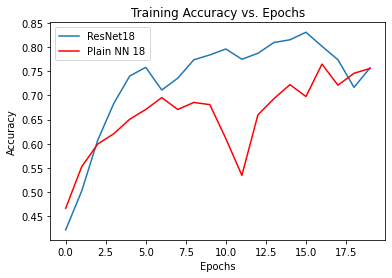

In [ ]:
#plot accuracy from each epoch
plt.plot(list(cpRN18.epoch_accuracy.values()), label = 'ResNet18')
plt.plot(list(cpNN18.epoch_accuracy.values()), label = 'Plain NN 18', c = 'red')
plt.title("Training Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

### Compare ResNet34 and Plain NN 34

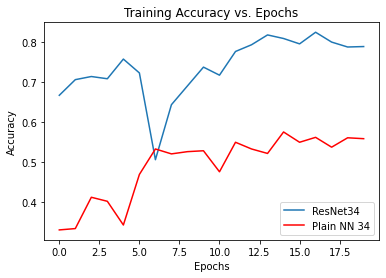

In [ ]:
#plot accuracy from each epoch
plt.plot(list(cpRN34.epoch_accuracy.values()), label = 'ResNet34')
plt.plot(list(cpNN34.epoch_accuracy.values()), label = 'Plain NN 34', c = 'red')
plt.title("Training Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

### Compare ResNet50 and Plain NN 50

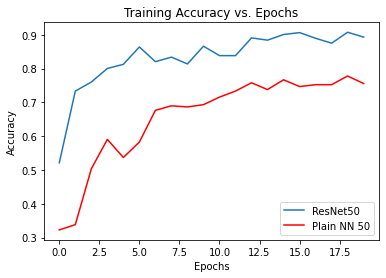

In [ ]:
#plot accuracy from each epoch
plt.plot(list(cpRN50.epoch_accuracy.values()), label = 'ResNet50')
plt.plot(list(cpNN50.epoch_accuracy.values()), label = 'Plain NN 50', c = 'red')
plt.title("Training Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

### Compare ResNet101 and Plain NN 101

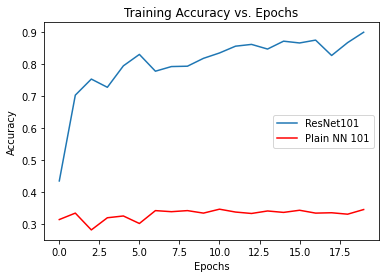

In [ ]:
#plot accuracy from each epoch
plt.plot(list(cpRN101.epoch_accuracy.values()), label = 'ResNet101')
plt.plot(list(cpNN101.epoch_accuracy.values()), label = 'Plain NN 101', c = 'red')
plt.title("Training Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

### Compare Plain NN 18 and Plain NN 101

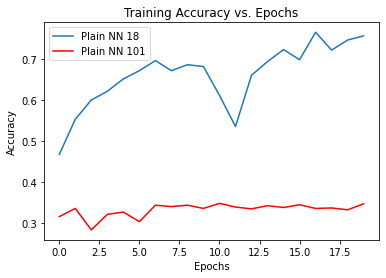

In [ ]:
#plot accuracy from each epoch
plt.plot(list(cpNN18.epoch_accuracy.values()), label = 'Plain NN 18')
plt.plot(list(cpNN101.epoch_accuracy.values()), label = 'Plain NN 101', c = 'red')
plt.title("Training Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

### Compare ResNet18 and ResNet101

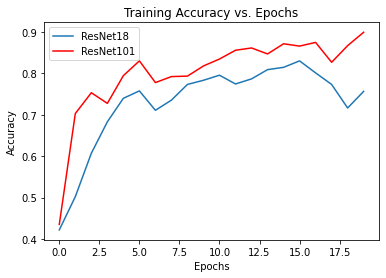

In [ ]:
#plot accuracy from each epoch
plt.plot(list(cpRN18.epoch_accuracy.values()), label = 'ResNet18')
plt.plot(list(cpRN101.epoch_accuracy.values()), label = 'ResNet101', c = 'red')
plt.title("Training Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

## Conclusion
From the above results, we see that as a plain neural network has deeper networks, its performance gets worse because of the problem of vanishing gradients and the problem of degradation. When we compare the performances of plain-NN-18 and plain-NN-101, there is a huge difference in training accuracy. However, the comparison between ResNet18 and ResNet101 shows that a residual network, which has more layers, results in almost similar or even better performance than smaller ones under 20 epochs.